In [88]:
import pandas as pd
from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='serif')
import palettable
%matplotlib inline
import csv
from astropy.time import Time
from datetime import datetime, date

In [2]:
time, rate, err, year, day, staterr, syserr, data_flag, timedelexp, timedelcoded, timedeldith=np.transpose(np.loadtxt('RapidBurster.lc.txt', skiprows=5))

Text(0,0.5,'Rate (ct/s)')

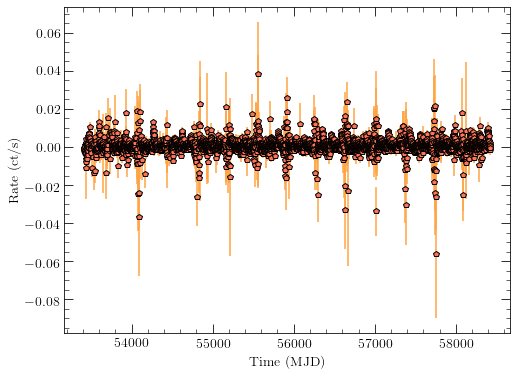

In [33]:
plt.figure(figsize=(8,6))
#plt.gca().axes.set_xticklabels([]) # To get rid of tick labels but not ticks
plt.minorticks_on()                # To plot minor ticks
plt.tick_params(axis='both', which='major', labelsize=14)    # To set tick label fontsize
plt.tick_params(axis='both', which='major', length=9)        # To set tick size
plt.tick_params(axis='both', which='minor', length=4.5)      # To set tick size
plt.tick_params(axis='both', which='both',direction='in',right='on', top='on')   # To plot ticks inwards instead of out
plt.errorbar(time, rate, yerr=err, fmt='p',markeredgecolor='k',ecolor=palettable.cubehelix.cubehelix3_16.mpl_colors[11],color=palettable.cubehelix.cubehelix3_16.mpl_colors[10])
plt.xlabel('Time (MJD)', fontsize=14)
plt.ylabel('Rate (ct/s)', fontsize=14)

In [11]:
t=Time(time, format='mjd')

In [159]:
t_yr=t.datetime


In [126]:
np.savetxt('t_yr', t_yr, fmt='%s')
np.savetxt('rate', rate)

In [158]:
##saved out time and rate separately, loaded each column into csv file with the header "ds" and "y" LOWERCASE
#saved as csv file and reloaded

In [153]:
df = pd.read_csv('rapidburster.csv')

###had to remove 02-29 (leap days)

In [151]:
df.head()

,ds,y
0,2005-02-14,-0.001910
1,2005-02-15,-0.000659
2,2005-02-16,-0.001290
3,2005-02-17,-0.000866
4,2005-02-18,-0.000563


In [152]:
m = Prophet()
m.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [154]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
4778,2010-12-27
4779,2010-12-28
4780,2010-12-29
4781,2010-12-30
4782,2010-12-31


In [155]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4778,2010-12-27,0.000312,-0.003979,0.005056
4779,2010-12-28,0.000551,-0.004005,0.005104
4780,2010-12-29,0.000484,-0.003948,0.005077
4781,2010-12-30,0.000105,-0.004783,0.004423
4782,2010-12-31,0.000396,-0.004075,0.004956


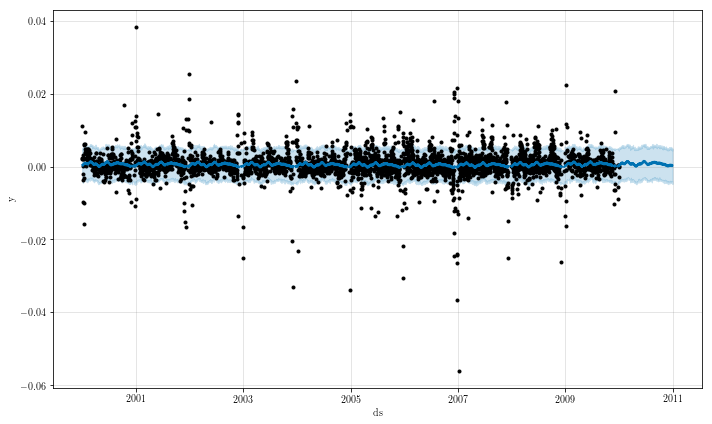

In [156]:
fig1 = m.plot(forecast)

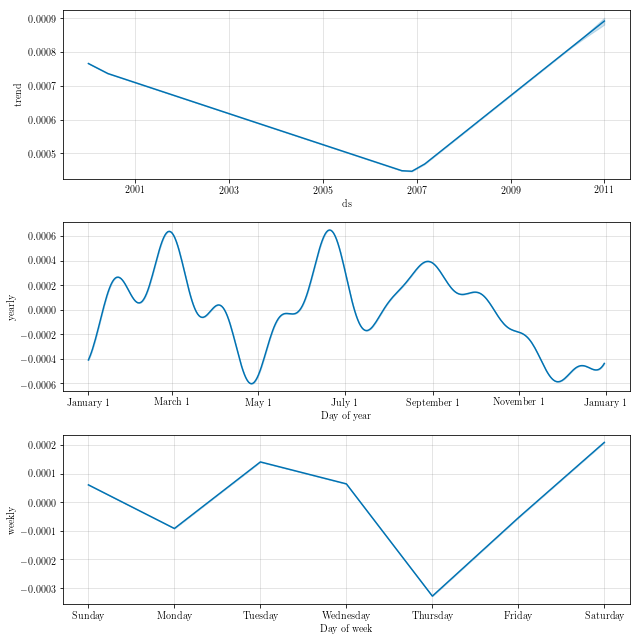

In [157]:
fig2 = m.plot_components(forecast)